## MonReader - Part 1

----

### Predicting flip or notflip pages using CNNs

**Objective.**  


**Model.**  

**Method (steps):**

1) 
2) 
3) 
4) 
5) 
   
   


----


#### 0. Imports and Environment

In [73]:
# Core imports
import os, sys, random, json, math
from pathlib import Path
from collections import Counter, defaultdict

In [74]:
import numpy as np
import matplotlib.pyplot as plt

In [75]:
from PIL import Image, ImageOps, ImageStat, UnidentifiedImageError

In [76]:
import torch, torchvision, torchaudio
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("torchaudio:", torchaudio.__version__)
print("built with CUDA:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))


torch: 2.6.0+cu124
torchvision: 0.21.0+cu124
torchaudio: 2.6.0+cu124
built with CUDA: 12.4
cuda available: True
gpu: NVIDIA GeForce GTX 1080 Ti


In [77]:
# reproducibility
SEED = 23
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# Access the datasets
DATA_ROOT = Path("data") / "images"
splits = ["training", "testing"]
classes = ["flip", "notflip"]

for split in splits:
    for cls in classes:
        p = DATA_ROOT / split / cls
        assert p.is_dir(), f"Missing folder: {p}"
print("Folder structure looks OK.")

Folder structure looks OK.


#### 1. EDA

#### 1.1 Count Images, detect corrupt files, and gather basic metadata

This pass will:
- count files per class,
- catch corrupt/unreadable images,
- record sizes and aspect ratios,
- note any non-RGB modes

In [78]:
def scan_split(split_path: Path):
    """Scan every split. Tracing the Image metadata and add corruptued files into a specific list(corrupt)"""
    rows = []
    corrupt = []
    for cls in classes:
        for f in (split_path/cls).glob("*"):
            if f.is_file():
                try:
                    with Image.open(f) as im:
                        im.load()
                        rows.append({
                            "path": str(f),
                            "split": split_path.name,
                            "label": cls,
                            "w": im.width,
                            "h": im.height,
                            "mode": im.mode,
                            "ratio": im.width / im.height if im.height else np.nan,
                        })
                except (UnidentifiedImageError, OSError) as e:
                    corrupt.append(str(f))
    return rows, corrupt        

In [79]:
all_rows, corrupt_files = [], []
for split in splits:
    rows, bad = scan_split(DATA_ROOT / split)
    all_rows.extend(rows)
    corrupt_files.extend(bad)

In [80]:
print(f"Total images (readable): {len(all_rows)}")
print(f"Corrupt/unreadable: {len(corrupt_files)}")
if corrupt_files:  # files with an Unidentified Image Error when opening
    print("Sample corrupt:", corrupt_files[:5])

Total images (readable): 2989
Corrupt/unreadable: 0


#### 1.2 Class balance and Image size distribution

In [81]:
import pandas as pd

In [82]:
df = pd.DataFrame(all_rows)

In [83]:
# save the dataframe into a csv file
extraction_table_file = "all_images.csv"
df.to_csv(DATA_ROOT / extraction_table_file)

In [84]:
# class counts
print("\nCounts by split/label:")
print(df.groupby(["split","label"]).size())


Counts by split/label:
split     label  
testing   flip        290
          notflip     307
training  flip       1162
          notflip    1230
dtype: int64


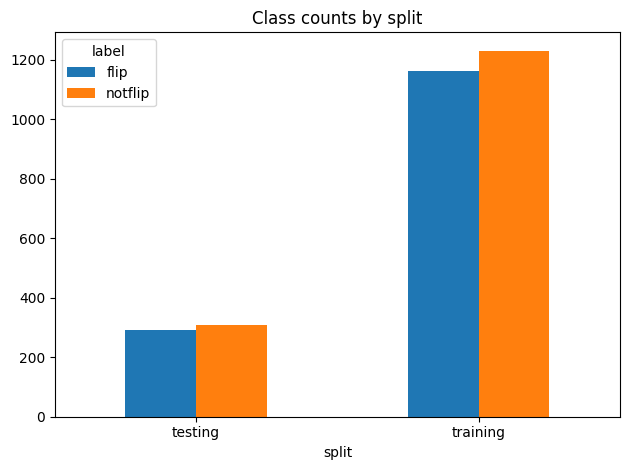

In [85]:
# Class balance bar chart
counts = df.groupby(["split","label"]).size().unstack(fill_value=0)
counts.plot(kind="bar", rot=0, title="Class counts by split")
plt.tight_layout(); plt.show()


We observe: 
- a train/test split of 80 to 20 %
- the classes are balanced in both splits

In [86]:
# overall size stats
print("\nSize stats (W,H) by split:")
print(df.groupby("split")[["w","h"]].describe())


Size stats (W,H) by split:
               w                                                            h  \
           count    mean  std     min     25%     50%     75%     max   count   
split                                                                           
testing    597.0  1080.0  0.0  1080.0  1080.0  1080.0  1080.0  1080.0   597.0   
training  2392.0  1080.0  0.0  1080.0  1080.0  1080.0  1080.0  1080.0  2392.0   

                                                               
            mean  std     min     25%     50%     75%     max  
split                                                          
testing   1920.0  0.0  1920.0  1920.0  1920.0  1920.0  1920.0  
training  1920.0  0.0  1920.0  1920.0  1920.0  1920.0  1920.0  


All the images have the same size: 1080x1920(width-height) no matter the split


#### 1.3 Visual spot-check a few images per class

In [87]:
def show_grid(paths, cols=5, size=3, title=None):
    rows = math.ceil(len(paths)/cols)
    plt.figure(figsize=(cols*size, rows*size))
    for i, p in enumerate(paths):
        with Image.open(p) as im:
            im = ImageOps.exif_transpose(im)  # respect EXIF orientation
            plt.subplot(rows, cols, i+1)
            plt.imshow(im)
            plt.axis("off")
            plt.title(Path(p).parent.name)
    if title: 
        plt.suptitle(title)
    plt.tight_layout()
    plt.show

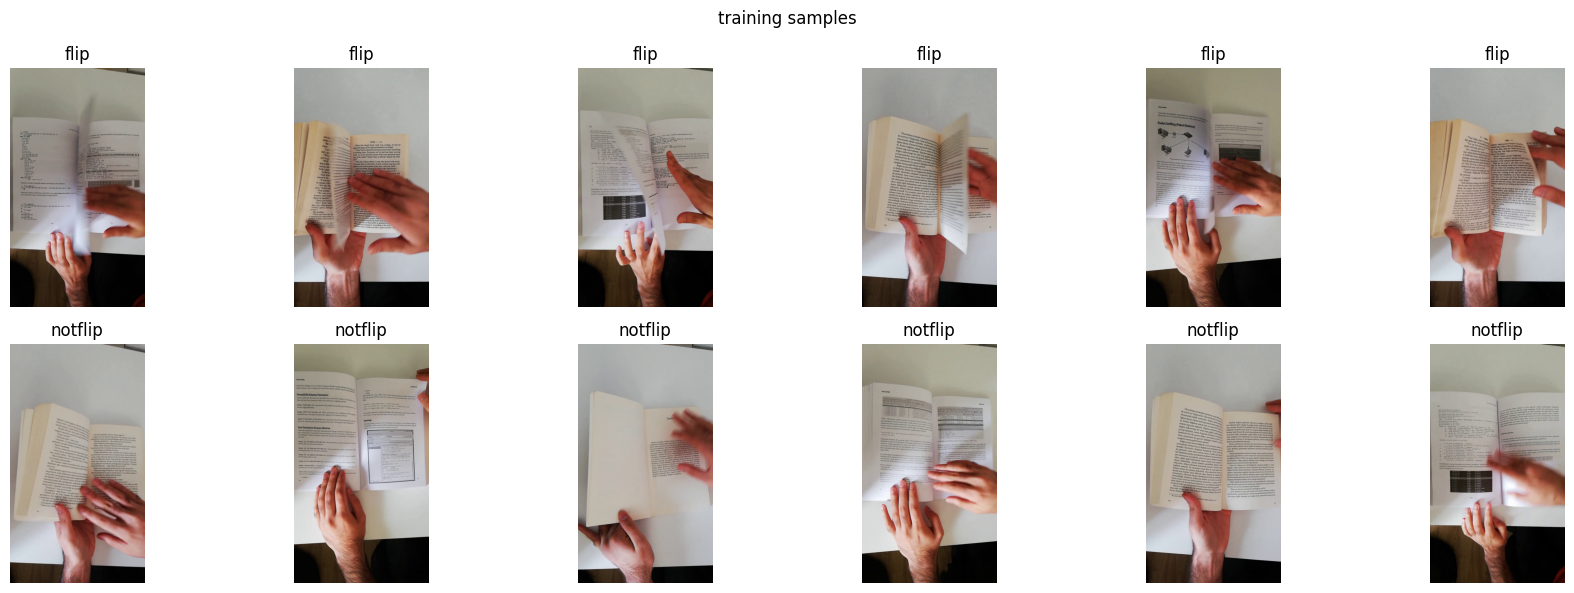

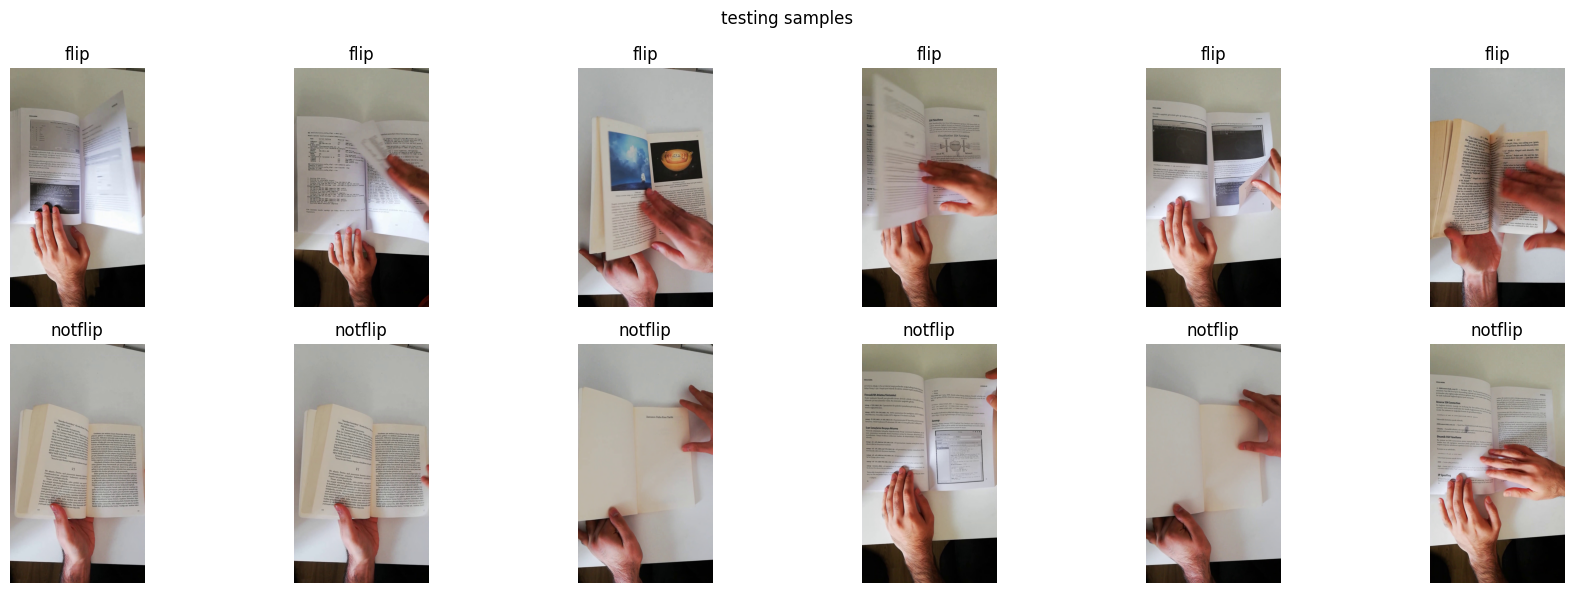

In [88]:
for split in splits:
    grid_paths = []
    for cls in classes:
        cls_paths = list((DATA_ROOT/split/cls).glob("*"))
        random.shuffle(cls_paths)
        grid_paths.extend(cls_paths[:6])
    show_grid(grid_paths, cols=6, title=f"{split} samples")

#### 1.4 Quick brightness & blur stats

In [89]:
import cv2

In [90]:
def image_brightness(im: Image.Image):
    """Calculate the average brightness (luminance) of an image
    using the (ITU-R BT.601 standard): Y=0.299R+0.587G+0.114B"""
    
    # take the mean of Y values, giving the average brightness across the entire image.
    stat = ImageStat.Stat(im.convert("L"))
    # return value form 0 to 255
    return stat.mean[0]  

def laplacian_var(np_img):
    """
    Compute the Laplacian operator to the input image to measure
    local intensity changes (edges), and then computes the variance of the resulting
    Laplacian map (or image). A high variance indicates a sharp image with many strong edges,
    while a low variance suggests a blurred or out-of-focus image.

    Returns: float
    Variance of the Laplacian values. Higher values correspond to sharper images,
    and lower values correspond to blurrier images.
    """
    return cv2.Laplacian(np_img, cv2.CV_64F).var()


In [91]:
# Calculate the quality stats

# helper function
def _stats(x):
    x = np.asarray(x)
    return {"mean": float(x.mean()), "std": float(x.std(ddof=1)), "n": int(x.size)}

def scan_quality_stats(label: str = "both", sample_n: int = 500, balanced: bool = False):
    """
    Compute brightness/blur per label and pooled across selected labels.

    Parameters
    ----------
    label : {"flip","notflip","both"}
        Subset to analyze. "both" analyzes both labels.
    sample_n : int
        Max samples per selected label. If balanced=True and label="both",
        samples min(sample_n, n_per_class) from EACH class; otherwise samples up to sample_n per class independently.
    balanced : bool
        If True with label="both", enforce equal sample size per class (useful for fair class comparison). Consider that the dataset is almost perfect balanced.

    Returns
    -------
    dict
        {
          "per_label": {
              "flip": {"brightness": {"mean","std","n"}, "blur": {...}},
              "notflip": {...}
          },
          "overall": {
              "brightness": {"mean","std","n"},
              "blur": {"mean","std","n"}
          }
        }
    """
    chosen = ["flip", "notflip"] if label == "both" else [label]
    results = {"per_label": {}, "overall": {}}

    # Collect per-image metrics
    all_brightness, all_blur = [], []
    
    for lab in chosen:
        subset = df[df["label"] == lab]
        take = min(sample_n, len(subset))
        sample = subset.sample(take, random_state=SEED)
        br, bl = [], []
        for p in sample["path"]:
            with Image.open(p) as im:
                im = ImageOps.exif_transpose(im).convert("RGB")
                br.append(image_brightness(im))
                bl.append(laplacian_var(np.array(im)))
        br = np.array(br); bl = np.array(bl)
        results["per_label"][lab] = {
            "brightness": {**_stats(br), "values": br},
            "blur": {**_stats(bl), "values": bl}
        }
        all_brightness.append(br)
        all_blur.append(bl)

    # Overall
    if all_brightness:
        pooled_brightness = np.concatenate(all_brightness)
        pooled_blur = np.concatenate(all_blur)
        results["overall"] = {
            "brightness": {**_stats(pooled_brightness), "values": pooled_brightness},
            "blur": {**_stats(pooled_blur), "values": pooled_blur},
        }

    return results


In [92]:
# Run the Quality Scan
res = scan_quality_stats(label="both", sample_n=500)

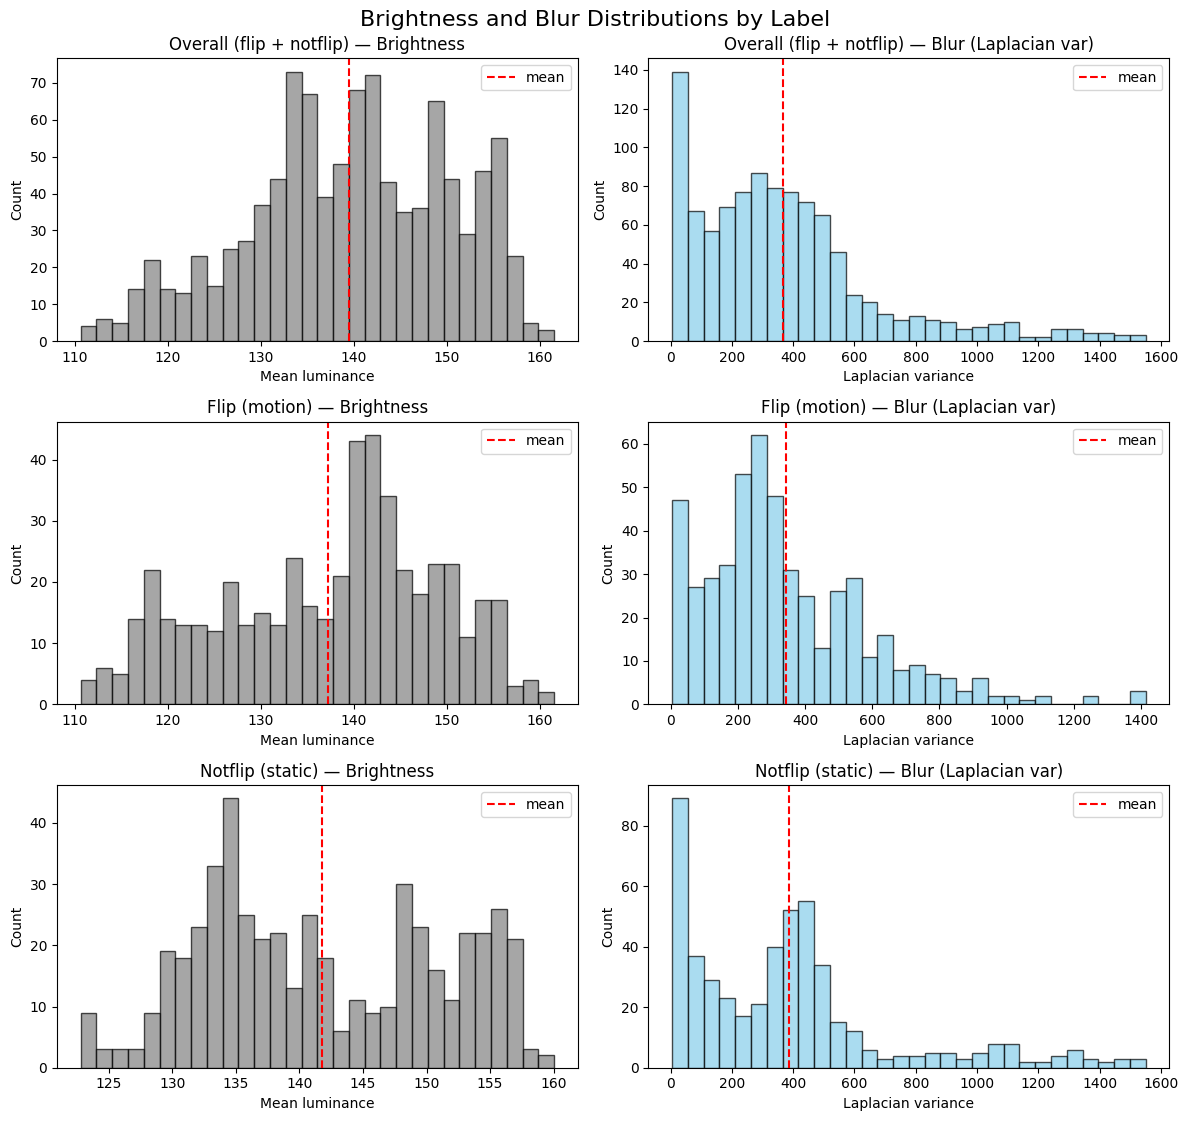

In [93]:
# Prepare figure to plot
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle("Brightness and Blur Distributions by Label", fontsize=16, y=0.93)

labels_order = ["overall", "flip", "notflip"]
titles = ["Overall (flip + notflip)", "Flip (motion)", "Notflip (static)"]

# Helper: build a small accessor so "overall"/labels use the right branch
def _get_block(res, key):
    return res["overall"] if key == "overall" else res["per_label"][key]

for i, lab in enumerate(labels_order):
    # Brightness
    blk = _get_block(res, lab)
    ax_bright = axes[i, 0]
    vals = blk["brightness"]["values"]
    ax_bright.hist(vals, bins=30, color='gray', alpha=0.7, edgecolor='black')
    ax_bright.set_title(f"{titles[i]} — Brightness")
    ax_bright.set_xlabel("Mean luminance")
    ax_bright.set_ylabel("Count")
    ax_bright.axvline(blk["brightness"]["mean"], color='red', linestyle='--', label='mean')
    ax_bright.legend()

    # Blur (Laplacian variance)
    ax_blur = axes[i, 1]
    vals = blk["blur"]["values"]
    ax_blur.hist(vals, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
    ax_blur.set_title(f"{titles[i]} — Blur (Laplacian var)")
    ax_blur.set_xlabel("Laplacian variance")
    ax_blur.set_ylabel("Count")
    ax_blur.axvline(blk["blur"]["mean"], color='red', linestyle='--', label='mean')
    ax_blur.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [94]:
from scipy.stats import mannwhitneyu  # for p-value

In [95]:
# Median and p-value calculations
# flip and notflip arrays
flip_blur = res["per_label"]["flip"]["blur"]["values"]
notflip_blur  = res["per_label"]["notflip"]["blur"]["values"]

# compute medians and p-value
flip_median = np.median(flip_blur)
notflip_median = np.median(notflip_blur)
u_stat, p_val = mannwhitneyu(flip_blur, notflip_blur, alternative='two-sided')

# print with 2-decimal formatting
print(f"Flip blur median: {np.median(flip_blur):.2f}")
print(f"Notflip blur median: {np.median(notflip_blur):.2f}")
u,p = mannwhitneyu(flip_blur, notflip_blur, alternative='two-sided')
print(f"Mann-Whitney U p-value: {p:.2f}")


Flip blur median: 286.79
Notflip blur median: 359.48
Mann-Whitney U p-value: 0.48


#### 1.5 Conclusions

The **analysis of brightness** and blur distributions across both labels reveals that **the dataset is generally well-balanced in exposure**, with no significant differences in brightness between flip (motion) and notflip (static) images. This indicates that lighting conditions are consistent across the two classes, minimizing bias from illumination effects.

Regarding **sharpness**, flip images show slightly lower median Laplacian variance (286.79) compared to notflip images (359.48), which aligns with the expectation that page-flip frames contain more motion blur. However, the Mann–Whitney U test (**p = 0.48**) indicates that this **difference is not statistically significant**, meaning the blur variation between the two classes is weak for direct classification.

In summary, while motion frames are on average somewhat blurrier, blur alone is not a reliable discriminative feature for detecting page flips. The classifier will likely need to learn from additional spatial or contextual cues beyond global sharpness differences.

----

#### 2. Model

#### 2.1 Pre-settings

In [96]:
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torchvision.transforms.functional as F


In [97]:
# train and test folders
TRAIN_DIR = DATA_ROOT/"training"
TEST_DIR  = DATA_ROOT/"testing"

# Target size that respects the 16:9 frames but is lighter than 1080x1920
# Downscaling x2
TARGET_H, TARGET_W = 540, 960   # keep multiples of 32; fits the available GPU
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)


In [98]:
# Aspect-preserving and resize
class ResizePad:
    """Resize preserving aspect ratio, then pad to (TARGET_H, TARGET_W)."""
    def __init__(self, out_h=TARGET_H, out_w=TARGET_W, fill=0):
        self.out_h = out_h
        self.out_w = out_w
        self.fill = fill
                
    def __call__(self, img: Image.Image):
        w, h = img.size
        scale = min(self.out_w / w, self.out_h / h)
        new_w, new_h = int(w * scale), int(h * scale)  
        img = F.resize(img, [new_h, new_w], antialias=True)
        pad_w = self.out_w - new_w  # considering that all the dataset images are 1080x1920, no need of padding!
        pad_h = self.out_h - new_h  # we will keep these lines of code for more general applications 
        
        # Pad evenly (left, top, right, bottom)
        pad_left  = pad_w // 2
        pad_right = pad_w - pad_left
        pad_top   = pad_h // 2
        pad_bottom= pad_h - pad_top
        img = F.pad(img, [pad_left, pad_top, pad_right, pad_bottom], fill=self.fill)
        return img


In [99]:
# Transforms
# Here we define the DataAugmentation transformations that we will apply over the input images
train_tfms = transforms.Compose([
    ResizePad(TARGET_H, TARGET_W, fill=0),
    transforms.RandomRotation(degrees=5, fill=0),
    #transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.2),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # mild
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),  # end step: Normalization considering IMAGENET Stats
])

# For the validation set we won't apply DataAugmentation
val_tfms = transforms.Compose([
    ResizePad(TARGET_H, TARGET_W, fill=0),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


**Data Augmentation and Normalization**

In this block we define the preprocessing and augmentation pipeline for the training and validation datasets.  
For training, we apply a few light transformations to slightly vary each image while keeping its original structure:

- **`ResizePad`**: resizes each frame to fit the target resolution while preserving the 16:9 aspect ratio, padding if necessary.  
- **`RandomRotation(degrees=5)`**: simulates small camera tilts or misalignments typical in handheld captures.  
- **`ColorJitter(brightness=0.1, contrast=0.1)`**: introduces mild lighting and contrast variation to improve robustness to illumination changes.  
- **`ToTensor()`**: converts the image to a PyTorch tensor with pixel values scaled to [0, 1].  
- **`Normalize(IMAGENET_MEAN, IMAGENET_STD)`**: standardizes pixel values using ImageNet statistics, matching the normalization used during pretraining.

For the validation set, only resizing, tensor conversion, and normalization are applied—no augmentation—so evaluation reflects the model’s true performance on clean, unaltered data.


#### 2.1.1 Preparing the Datasets and Dataloaders

The test set should be untouched until the very end. For model selection (LR, epochs, unfreezing, etc.) we need a validation split from the training folder.

Then, we will create a stratified train/val split from TRAIN_DIR without moving files. It keeps the existing train_tfms / val_tfms, avoids leakage, and is reproducible.

In [100]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset

In [101]:
# Datasets / Dataloaders
#
# ImageFolder does the following automatically:
# Sorts the subfolder names alphabetically and assings a numeric class index to each:
# 'flip' -> label 0
# 'notflip' -> label 1
# because 'flip' comes before 'notflip' alphabetically.)
# Then, it stores tuples of: (images_tensor, class_index)

# Two mirrored datasets over the same files: one with train tfms, one with val tfms
train_ds_full = datasets.ImageFolder(root=str(TRAIN_DIR), transform=train_tfms)
val_ds_full   = datasets.ImageFolder(root=str(TRAIN_DIR), transform=val_tfms)
test_ds = datasets.ImageFolder(root=str(TEST_DIR), transform=val_tfms)


# Targets for stratification (works across torchvision versions)
targets = getattr(train_ds_full, "targets", [y for _, y in train_ds_full.samples])

# Stratified split (20% of TRAIN_DIR becomes validation)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, val_idx = next(sss.split(np.zeros(len(targets)), targets))

# Subset the mirrored datasets using the same indices
train_ds = Subset(train_ds_full, train_idx)
val_ds   = Subset(val_ds_full,   val_idx)

# OLD: erase me!
#train_ds = datasets.ImageFolder(root=str(TRAIN_DIR), transform=train_tfms)
#val_ds   = datasets.ImageFolder(root=str(TEST_DIR),  transform=val_tfms)


In [111]:
BATCH_SIZE = 16  # can be reduced if the GPU's RAM is short
TEST_BATCH_SIZE = BATCH_SIZE  
NUM_WORKERS = 0  # safest setting on Windows
pin_memory = torch.cuda.is_available()

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=pin_memory, persistent_workers=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=pin_memory, persistent_workers=False)
test_loader = DataLoader(test_ds, batch_size=TEST_BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=pin_memory, persistent_workers=False)


print("Stratified split from TRAIN_DIR")
print("  Train size:", len(train_ds))
print("  Val size:  ", len(val_ds))
print("TEST set ready (held out until final evaluation)")
print("  Test size:", len(test_ds))


Stratified split from TRAIN_DIR
  Train size: 1913
  Val size:   479
TEST set ready (held out until final evaluation)
  Test size: 597


#### 2.2 Model Setup

In [112]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### ResNet18
- paper: https://arxiv.org/pdf/1512.03385

### Model Selection

For this project, we selected **ResNet18** as the convolutional backbone for the binary classification task of predicting whether a page is being flipped or not.

ResNet18 is a member of the Residual Networks (ResNet) family introduced by He et al. (2015) (https://arxiv.org/pdf/1512.03385), which solved the vanishing gradient problem in deep networks by introducing **residual (skip) connections**. These connections allow the model to learn effectively even as the number of layers increases, resulting in improved stability and convergence.

In this first implementation, we use the pretrained weights from **ImageNet** (`ResNet18_Weights.IMAGENET1K_V1`), which allows the network to start from a rich feature space learned from millions of natural images. We then fine-tune only the final classification head to adapt the pretrained model to our specific domain, distinguishing *flip* (motion) versus *notflip* (static) document frames.


### ResNet18 Architecture 
<img src="./sup_imgs/Original-ResNet-18-Architecture.png" width="1000" style="vertical-align: middle;"/>


#### ResNet18 Stages and Their Function

| Stage | Description |
|--------|-------------|
| **conv1 (7×7, stride=2, pad=3)** | Extracts low-level edges and textures. Halves spatial size. |
| **maxpool (3×3, stride=2, pad=1)** | Keeps only the strongest local features. Halves spatial size again. |
| **layer1 (2 basic blocks, stride=1)** | Keeps resolution. Refines low-level details. |
| **layer2 (stride=2)** | Downsamples (×½) and increases channels to 128. Learns more abstract shapes. |
| **layer3 (stride=2)** | Downsamples again (×½). Mid-level features like page corners or hand edges. |
| **layer4 (stride=2)** | Downsamples once more. Extracts high-level semantic features. |
| **avgpool (1×1 global average pooling)** | Collapses each feature map into a single scalar (spatial average). |
| **fc (fully connected)** | Outputs a single logit for binary classification. |

### **Pytorch ResNet18_Weights.IMAGENET1K_V1**  
These weights reproduce closely the results of the paper using a simple training recipe. Also available as `ResNet18_Weights.DEFAULT`.

| Metric / Property | Value |
|---|---|
| **acc@1 (ImageNet-1K)** | 69.758 |
| **acc@5 (ImageNet-1K)** | 89.078 |
| **min_size** | height = 1, width = 1 |
| **categories** | tench, goldfish, great white shark, … *(997 omitted)* |
| **num_params** | 11,689,512 |
| **recipe** | see docs (training recipe) |
| **GFLOPS** | 1.81 |
| **File size** | 44.7 MB |

The inference transforms are available at `ResNet18_Weights.IMAGENET1K_V1.transforms` and perform the following preprocessing operations:

- Accepts `PIL.Image`, batched `(B, C, H, W)` and single `(C, H, W)` `torch.Tensor`.
- Resize to `resize_size=[256]` with `InterpolationMode.BILINEAR`.
- Center-crop to `crop_size=[224]`.
- Rescale to `[0.0, 1.0]`, then normalize with `mean=[0.485, 0.456, 0.406]` and `std=[0.229, 0.224, 0.225]`.

***source: docs.pytorch.org***


### Step-by-Step Image Size Reduction through ResNet18

Below is a detailed explanation of how **ResNet18** processes an image through its layers, showing how the spatial dimensions change at each step.  
We assume an **input image of size 3×540×960 (C×H×W)**, matching our project configuration.

---

#### Convolution Output Formula (PyTorch)
For each convolution or pooling layer, the output size is computed as:

$
\text{out} = \left\lfloor \frac{\text{in} + 2P - K}{S} \right\rfloor + 1
$

where:
- \(K\) = kernel size  
- \(S\) = stride  
- \(P\) = padding  


---

#### Spatial Size Progression for 3×540×960 Input

| Stage | Operation | Output Size (C×H×W) |
|--------|------------|----------------------|
| Input | — | **3×540×960** |
| conv1 | 7×7, stride=2, pad=3 | **64×270×480** |
| maxpool | 3×3, stride=2, pad=1 | **64×135×240** |
| layer1 | 2 blocks (stride=1) | **64×135×240** |
| layer2 | 2 blocks (first with stride=2) | **128×68×120** |
| layer3 | 2 blocks (first with stride=2) | **256×34×60** |
| layer4 | 2 blocks (first with stride=2) | **512×17×30** |
| avgpool | AdaptiveAvgPool2d(1×1) | **512×1×1** |
| fc | Linear(512→1) | **1 (logit)** |

**Example calculation (height):**
- After `conv1`: (540 + 6 - 7) / 2 + 1 = 270  
- After `maxpool`: (270 + 2 - 3) / 2 + 1 = 135  
- After `layer2` stride-2 block: (135 + 2 - 3) / 2 + 1 = 68  

The same logic applies to the width dimension (960 → 480 → 240 → 120 → 60 → 30).

---



#### 2.3 Transfer Learning from pre-trained ResNet18 for **ImageNet**

We initialize **ResNet18** with **ImageNet-1K** pretrained weights to exploit features learned from 1.2M images across 1,000 classes. These early-to-mid-level representations (edges, textures, shapes) transfer well to our task and reduce data and compute needs.

Below, we load `ResNet18_Weights.IMAGENET1K_V1` and **freeze the backbone** so only the task-specific head will be trained next. This setup speeds convergence, lowers overfitting risk on our smaller dataset, and cuts GPU memory devoted to gradients.

**Why freeze?**
- Faster training and simpler optimization
- Fewer trainable parameters (regularization effect)
- Strong baseline. We can later unfreeze top blocks for targeted fine-tuning.

In [113]:
# Load ImageNet-pretrained ResNet18 and freeze backbone
weights = models.ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)

# freeze backbone
for p in model.parameters():
    p.requires_grad = False


In [114]:
# Replace classifier head: single logit for binary classification

# Read the input dimensionality of the existing classification layer (ResNet18: 512 after AVGPool)
in_features = model.fc.in_features

# Replace the ImageNet 1000-way classifier with a 1-logit head for binary classification
# (keeps backbone features, outputs shape: [batch_size, 1])
# Consider that we will use BCEWithLogitsLoss during training (which combines a sigmoid + binary cross-entropy in a stable way).
model.fc = nn.Linear(in_features, 1)

# Move the whole model (frozen backbone + new head) to the selected device GPU
model = model.to(device)


In [115]:
# Loss (binary, with logits)
# Important: nn.BCEWithLogitsLoss() already includes a sigmoid activation internally and it does so in a numerically stable way.
criterion = nn.BCEWithLogitsLoss() 

# # Equivalent, but less stable:
# criterion = nn.BCELoss()
# outputs = torch.sigmoid(logits)
# loss = criterion(outputs, targets)

In [116]:
# Optimizer: head-only params

# Collect only the parameters that should be trained (FC layer params).
# We previously froze the backbone (requires_grad=False), so this filters to the new head
# (and any other layers were intentionally left trainable). Passing only these to the optimizer
# ensures gradients and updates are applied exclusively to trainable params.
head_params = [p for p in model.parameters() if p.requires_grad]

# Passing head_params to the optimizer ensures only the head gets updated during backprop (transfer-learning plan).
optimizer = torch.optim.AdamW(
    head_params, 
    lr=3e-4, 
    weight_decay=1e-4
    )

# Optional scheduler (cosine with warmup-like plateau)


# Reduce the learning rate when a monitored validation metric stops improving.
# - mode='max': the metric should increase
# - factor=0.5: halve the LR when a plateau is detected
# - patience=2: wait 2 epochs without improvement before reducing LR
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

print("Trainable parameters:", sum(p.numel() for p in head_params))


Trainable parameters: 513


513 params = 512 weights + 1 bias 
from FC linear layer (with no activation)

In [117]:
# Print the architecture (top-level modules)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Notice that the trainable params are those from the 'fc' layer (the output layer)

#### 2.3 Training

In [118]:
from sklearn.metrics import roc_auc_score

In [119]:
def eval_epoch_with_auc(model, loader, device):
    model.eval()
    total, correct = 0, 0
    running_loss = 0.0

    all_probs = []
    all_targets = []

    with torch.no_grad():
        for imgs, labels in loader:
            labels_f = labels.float().unsqueeze(1).to(device)  # [B] → [B,1]
            imgs = imgs.to(device)

            logits = model(imgs)                    # [B,1]
            loss = criterion(logits, labels_f)      # BCEWithLogitsLoss

            probs = torch.sigmoid(logits)           # [B,1]
            preds = (probs >= 0.5).float()

            correct += (preds == labels_f).sum().item()
            total   += labels_f.numel()
            # rescales the averaged batch loss back to total loss so that final avg_loss reflects the true per-sample average 
            # across the entire dataset
                # loss.item():	average loss per sample in batch
                # labels_f.size(0):	number of samples in batch
            running_loss += loss.item() * labels_f.size(0)

            # collect for AUROC 
            # Do the calculation on CPU, avoid overloading the GPU
            all_probs.append(probs.squeeze(1).cpu())
            all_targets.append(labels.cpu())

    avg_loss = running_loss / max(1, total)
    acc = correct / max(1, total)

    # Concatenate and compute AUROC (handle edge case: single-class)
    all_probs = torch.cat(all_probs).numpy()
    all_targets = torch.cat(all_targets).numpy()

    try:
        auc = roc_auc_score(all_targets, all_probs)
    except ValueError:
        # happens if the epoch had only one class present in targets
        auc = float('nan')

    return avg_loss, acc, auc


#### 2.3.1 Eval the model over the val set before training 

In [120]:
val_loss, val_acc, val_auc = eval_epoch_with_auc(model, val_loader, device)
scheduler.step(val_acc)  # still stepping on accuracy (mode='max')
print(f"val_loss: {val_loss:.4f} acc: {val_acc:.3f} auc: {val_auc:.3f}")


val_loss: 0.7015 acc: 0.486 auc: 0.485


As expected, the evaluation of the model using AUCROC metric using the validation set is **not good**. 

test: val_loss: 0.7061 acc: 0.486 auc: 0.480
val: val_loss: 0.7015 acc: 0.486 auc: 0.485

#### 2.3.1 "train-the-head" loop 

In [122]:
from copy import deepcopy
from time import time

In [124]:
# Train the classification head (backbone frozen)

def train_one_epoch(model, loader, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels_f = labels.float().unsqueeze(1).to(device)  # [B] -> [B,1]

        # reset grads from previous iteration
        optimizer.zero_grad()
        # forward pass
        logits = model(imgs)                  # [B,1]
        # loss computation
        loss = criterion(logits, labels_f)    # BCEWithLogitsLoss
        # backward pass
        loss.backward()
        # update the params
        optimizer.step()

        # Metrics
        with torch.no_grad():
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            correct += (preds == labels_f).sum().item()
            total   += labels_f.numel()
            running_loss += loss.item() * labels_f.size(0)

    # Epoch aggregates
    avg_loss = running_loss / max(1, total)
    acc = correct / max(1, total)
    return avg_loss, acc


In [ ]:
EPOCHS = 8
best_state = None
best_val_auc = -float('inf')

for epoch in range(1, EPOCHS+1):
    t0 = time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc, val_auc = eval_epoch_with_auc(model, val_loader, device)

    # step LR scheduler on the AUCROC metric
    scheduler.step(val_auc)

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_state = deepcopy(model.state_dict())

    dt = time() - t0
    print(f"Epoch {epoch:02d} | "
          f"train_loss: {train_loss:.4f} acc: {train_acc:.3f} | "
          f"val_loss: {val_loss:.4f} acc: {val_acc:.3f} auc: {val_auc:.3f} | "
          f"time: {dt:.1f}s")

# restore best validation model
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Loaded best model (val_acc={best_val_auc:.3f}).")
